In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")


In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# Add a State of the Graph

The first thing you do when you define a graph is define the State of the graph. 



# What is State of Graph?

The State consists of 2 things:
1. The schema of the graph 
2. A reducer functions which specify how to apply updates to the state. 



# State definition in our example

```State``` is a dictionary that inherits from ```TypedDict```.

```messages``` is a key in that dictionary ```State```. 

The value for this key is a list and it uses "Annotated" type hint.
The messages key is annotated with the add_messages reducer function.

This annotation which tells LangGraph to append new messages to the existing list, rather than overwriting it. 

State keys without an annotation will be overwritten by each update, storing the most recent value. 



In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Way to understand the concept of State Update
So basically when we say "updating" the ```State``` -> we essentially in this case means updating the list of messages in key ```messages```

# Create the StateGraph instance

create an instance of a StateGraph using the State class as its argument.



In [4]:
graph_builder = StateGraph(State)

# So now our graph knows two things:

1. Every node we define will receive the current ```State``` as input and return a value that updates that state.
2. Messages will be appended to the current list, rather than directly overwritten. 
3. This is communicated via the prebuilt ```add_messages``` function in the Annotated syntax.

# Add a "chatbot" node. 


Nodes represent units of work. They are typically regular python functions.


This chatbot node function takes the current ```State``` as input and returns a state with an updated ```messages``` key. 

This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the llm's response messages to whatever messages are already in the state.

In [5]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Add the node to the graph

In [6]:
graph_builder.add_node("chatbot", chatbot)

# Add an entry point. 

This tells our graph where to start its work each time we run it.


In [9]:
graph_builder.set_entry_point("chatbot")


# set a finish point. 

This instructs the graph "any time this node is run, you can exit."

In [10]:
graph_builder.set_finish_point("chatbot")

Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

In [11]:
graph = graph_builder.compile()

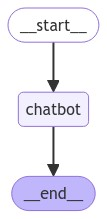

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
user_input = "Who is Elon Musk? Tell me in 10 words"

In [39]:
response=graph.invoke({"messages": ("user", user_input)})

# Note: The output of this grap again would be a state.

A dictionary containing a key 'messages' with a value that is a list. The list contains the list of messages.

In [40]:
response

{'messages': [HumanMessage(content='Who is Elon Musk? Tell me in 10 words', id='33a435db-76fe-4450-9b30-e513520deb70'),
  AIMessage(content='Elon Musk is a billionaire entrepreneur, CEO, and innovator.', response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 18, 'total_tokens': 32}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-5458fd5d-e042-43ba-9cc8-0c10edca9c77-0', usage_metadata={'input_tokens': 18, 'output_tokens': 14, 'total_tokens': 32})]}

In [50]:
response["messages"][1].content

'Elon Musk is a billionaire entrepreneur, CEO, and innovator.'

# For streaming output

In [44]:
stream=graph.stream({"messages": ("user", user_input)})

In [42]:
for event in stream:
    print(event)

{'chatbot': {'messages': [AIMessage(content='Entrepreneur, CEO, inventor; known for Tesla, SpaceX, Neuralink, innovation.', response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 18, 'total_tokens': 37}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-b554e3c8-a348-48b2-9654-3e93a99565de-0', usage_metadata={'input_tokens': 18, 'output_tokens': 19, 'total_tokens': 37})]}}


In [45]:
for event in stream:
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: Elon Musk is a billionaire entrepreneur, CEO, and inventor.


In [13]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: Elon Musk is a prominent entrepreneur and businessman known for his role in several high-profile technology companies. He was born on June 28, 1971, in Pretoria, South Africa. Musk is the CEO and lead designer of SpaceX, a private aerospace manufacturer and space transportation company; the CEO and product architect of Tesla, Inc., an electric vehicle and clean energy company; and has been involved in various other ventures, including Neuralink (focused on brain-computer interfaces) and The Boring Company (focused on tunnel construction and infrastructure).

Musk is known for his visionary ideas, including plans for colonizing Mars, advancing sustainable energy solutions, and developing high-speed transportation systems like the Hyperloop. He has made headlines for his ambitious goals, innovative approaches, and sometimes controversial statements and actions.
Assistant: Elon Musk is a billionaire entrepreneur, inventor, and engin